<a href="https://colab.research.google.com/github/iisuslik43/dul/blob/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r "drive/My Drive/dul/" .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! pip install pymorphy2 >> /dev/null
! pip install transformers >> /dev/null
! pip install wandb >> /dev/null
! wandb login b569130067842c47dc059479b75930c8f598012a

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import pickle
import torch.nn.functional as F
import os
import csv

import wandb
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Sampling

In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
  [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

def sample_data_3():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
data1 = sample_data_1()
data2 = sample_data_2()
data3, y3 = sample_data_3()

#Models code


In [0]:
class VAE1(nn.Module):
  def __init__(self, dim=2, latent_dim=2):
    super().__init__()
    self.dim = dim
    self.latent_dim = latent_dim

    self.normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    self.encoder = nn.Sequential(
      nn.Linear(self.dim, 32),
      nn.ReLU(True)
    )

    self.mu_z = nn.Linear(32, self.latent_dim)
    self.gamma_z = nn.Linear(32, self.latent_dim ** 2)

        

    self.decoder = nn.Sequential(
      nn.Linear(sel.latent_dim, 32),
      nn.ReLU(True)
    )

    self.mu_x = nn.Linear(32, self.dim)
    self.gamma_x = nn.Linear(32, self.dim ** 2)

  def sample(self, mu, gamma):
    if self.training:
        gamma = torch.exp(0.5 * gamma)
        #std_z = Variable(torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float())
        std_z = self.normal.sample(mu.shape).to(device).reshape(-1, 1, 2)
        encoding = (std_z @ gamma).reshape(-1, 2) + mu
        return encoding
    else:
        return mu

  def encode(self, x):
    x = self.encoder(x)
    mu = self.mu_z(x)
    gamma = self.gamma_z(x)
    gamma = gamma.reshape(-1, 2, 2)
    return mu, gamma

  def decode(self, z):
    z = self.decoder(z)
    mu = self.mu_x(z)
    gamma = self.gamma_x(z)
    gamma = gamma.reshape(-1, 2, 2)
    return mu, gamma

  def kl(self, mu, gamma):
    dim = mu.shape[1]
    return 0.5 * ((gamma * torch.eye(dim).to(device)).sum(dim=(1, 2)) + (mu**2).sum(dim=-1) - dim - torch.log(gamma.det())).sum() / mu.shape[0]

  def forward(self, x):
    mu_z, gamma_z = self.encode(x)
    z = self.sample(mu_z, gamma_z)
    mu_x, gamma_x = self.decode(z)
    x1 = self.sample(mu_x, gamma_x)
    return x1, self.kl(mu_z, gamma_z)
    

In [0]:
class VAE2(nn.Module):
  def __init__(self, dim=2, latent_dim=2):
    super().__init__()
    self.dim = dim
    self.latent_dim = latent_dim

    self.normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    self.encoder = nn.Sequential(
      nn.Linear(self.dim, 32),
      nn.ReLU(True)
    )

    self.mu_z = nn.Linear(32, self.latent_dim)
    self.gamma_z = nn.Linear(32, self.latent_dim ** 2)

        

    self.decoder = nn.Sequential(
      nn.Linear(self.latent_dim, 32),
      nn.ReLU(True)
    )

    self.mu_x = nn.Linear(32, self.dim)
    self.gamma_x = nn.Linear(32, 1)

  def sample(self, mu, gamma):
    if self.training:
        gamma = torch.exp(0.5 * gamma)
        #std_z = Variable(torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float())
        std_z = self.normal.sample(mu.shape).to(device).reshape(-1, 1, 2)
        encoding = (std_z @ gamma).reshape(-1, 2) + mu
        return encoding
    else:
        return mu

  def encode(self, x):
    x = self.encoder(x)
    mu = self.mu_z(x)
    gamma = self.gamma_z(x)
    gamma = gamma.reshape(-1, 2, 2)
    return mu, gamma

  def decode(self, z):
    z = self.decoder(z)
    mu = self.mu_x(z)
    gamma = self.gamma_x(z)
    return mu, gamma

  def kl(self, mu, gamma):
    dim = mu.shape[1]
    return 0.5 * ((gamma * torch.eye(dim).to(device)).sum(dim=(1, 2)) + (mu**2).sum(dim=-1) - dim - torch.log(gamma.det())).sum() / mu.shape[0]

  def forward(self, x):
    mu_z, gamma_z = self.encode(x)
    z = self.sample(mu_z, gamma_z)
    mu_x, gamma_x = self.decode(z)
    gamma_x = gamma_x.repeat((1, self.dim ** 2)).reshape(mu_x.shape[0], self.dim, self.dim) * torch.eye(self.dim).to(device)
    x1 = self.sample(mu_x, gamma_x)
    return x1, self.kl(mu_z, gamma_z)
    

In [0]:
class VAELoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
  
  def forward(self, target, output, kl):
    l2 = self.mse(output, target)
    return l2 + kl, l2

In [0]:
def train(model, criterion, data, n_epochs=10, wandb_name=None, batch_size=128):
  split = int(len(data) * 0.8)
  dataset_train = torch.utils.data.DataLoader(data[:split],
                                              batch_size=batch_size,
                                              shuffle=True)
  dataset_test = torch.utils.data.DataLoader(data[split:],
                                             batch_size=batch_size,
                                             shuffle=True)
  optimizer = torch.optim.Adam(params=model.parameters())
  if wandb_name is not None:
    wandb.init(name=wandb_name, project="dul-hw3-vae")
    wandb.watch(model)
  for epoch in tqdm(range(1, n_epochs + 1)):
      train_losses = {'ELBO': [], 'KL': [], 'L2': []}
      test_losses = {'ELBO': [], 'KL': [], 'L2': []}
      for x_batch in dataset_train:
          optimizer.zero_grad()
          x_batch = x_batch.float().to(device)
          output, kl = model(x_batch)
          loss, l2 = criterion(x_batch, output, kl)
          loss.backward()
          optimizer.step()

          train_losses['ELBO'].append(loss.item())
          train_losses['KL'].append(kl.item())
          train_losses['L2'].append(l2.item())

      with torch.no_grad():
          model.eval()
          for x_test in dataset_test:
              x_test = x_test.float().to(device)
              output_test, kl_test = model(x_test)
              loss, l2 = criterion(x_test, output_test, kl_test)

              test_losses['ELBO'].append(loss.item())
              test_losses['KL'].append(kl_test.item())
              test_losses['L2'].append(l2.item())
          model.train()
      if wandb_name is not None:
          loss_log = {}
          for name, values in train_losses.items():
            loss_log[name + ' train'] = np.mean(values)
          for name, values in test_losses.items():
            loss_log[name + ' test'] = np.mean(values)
          wandb.log(loss_log)

# 1 a


In [14]:
model_11 = VAE1().to(device)
train(model_11, VAELoss(), data1, n_epochs=40, wandb_name='Method # 1')

In [13]:
model_12 = VAE2().to(device)
train(model_12, VAELoss(), data1, n_epochs=40, wandb_name='Method # 1')

In [0]:
def sample(model):
    with torch.no_grad():
        for i in range(20):
          z = model.normal.sample((100, 2)).reshape(100, 2).to(device)
          mu_x, gamma_x = model.decode(z)
          x1 = model.sample(mu_x, gamma_x).cpu().numpy()
          plt.plot(x1[:,0], x1[:, 1], 'bo')
        plt.show()

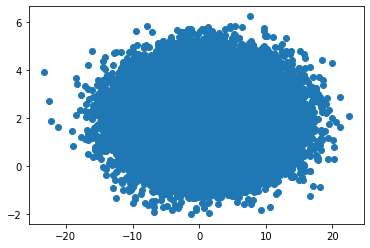

In [46]:
plt.plot(data1[:,0], data1[:,1], 'bo')
plt.show()

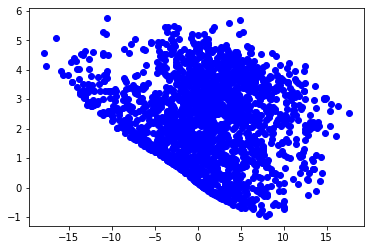

In [55]:
model_11.eval()
sample(model_11)

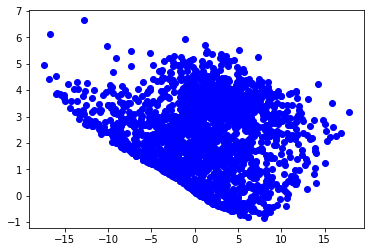

In [56]:
model_11.train()
sample(model_11)

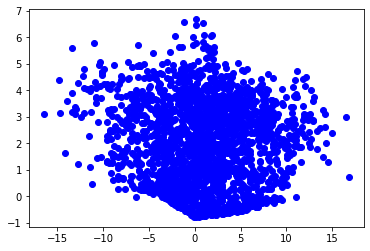

In [57]:
model_12.eval()
sample(model_12)

In [58]:
model_12.train()
sample(model_12)

RuntimeError: ignored

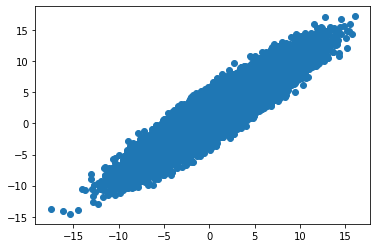

In [20]:
plt.plot(data2[:,0], data2[:,1], 'bo')
plt.show()

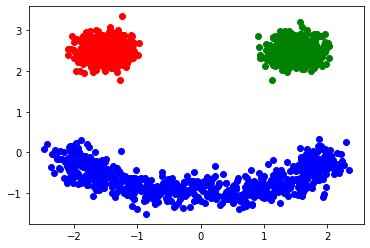

#1 b

In [0]:
for (x1, x2), y in zip(data3[:2000], y3[:2000]):
  colors = {0: 'r', 1: 'g', 2 : 'b'}
  plt.plot(x1, x2, 'o', color=colors[y])
plt.show()

# 2 a


In [0]:
with open('dul/hw3-q2.pkl', 'rb') as f:
  svhn_dataset = pickle.load(f)

In [17]:
svhn_dataset['test'][0].max(), svhn_dataset['test'][0].min()

(125, 1)

In [0]:
class VAE_big(nn.Module):
  def __init__(self, dim=50, latent_dim=50):
    super().__init__()
    self.dim = dim
    self.latent_dim = latent_dim

    self.normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    self.encoder = nn.Sequential(
      nn.Linear(self.dim, 32),
      nn.ReLU(True)
    )

    self.mu_z = nn.Linear(32, self.latent_dim)
    self.gamma_z = nn.Linear(32, self.latent_dim ** 2)

        

    self.decoder = nn.Sequential(
      nn.Linear(sel.latent_dim, 32),
      nn.ReLU(True)
    )

    self.mu_x = nn.Linear(32, self.dim)
    self.gamma_x = nn.Linear(32, self.dim ** 2)

  def sample(self, mu, gamma):
    if self.training:
        gamma = torch.exp(0.5 * gamma)
        #std_z = Variable(torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float())
        std_z = self.normal.sample(mu.shape).to(device).reshape(-1, 1, 2)
        encoding = (std_z @ gamma).reshape(-1, 2) + mu
        return encoding
    else:
        return mu

  def encode(self, x):
    x = self.encoder(x)
    mu = self.mu_z(x)
    gamma = self.gamma_z(x)
    gamma = gamma.reshape(-1, 2, 2)
    return mu, gamma

  def decode(self, z):
    z = self.decoder(z)
    mu = self.mu_x(z)
    gamma = self.gamma_x(z)
    gamma = gamma.reshape(-1, 2, 2)
    return mu, gamma

  def kl(self, mu, gamma):
    dim = mu.shape[1]
    return 0.5 * ((gamma * torch.eye(dim).to(device)).sum(dim=(1, 2)) + (mu**2).sum(dim=-1) - dim - torch.log(gamma.det())).sum() / mu.shape[0]

  def forward(self, x):
    mu_z, gamma_z = self.encode(x)
    z = self.sample(mu_z, gamma_z)
    mu_x, gamma_x = self.decode(z)
    x1 = self.sample(mu_x, gamma_x)
    return x1, self.kl(mu_z, gamma_z)
    